# Utilisation de LangGraph pour la récupération de paramètres

Ouvrir un tunnel vers la machine QDrant avec `ssh -L 6333:192.168.0.204:6333 ysabell`

In [41]:
# cd langchain
# python -m venv .venv && source .venv/bin/activate
# !pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph python-decouple ipywidgets markdown 

In [42]:
import getpass
import os
import json
from decouple import Config, RepositoryEnv
import requests
from bs4 import BeautifulSoup
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain.agents import create_openai_functions_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import functools

import markdown 
from IPython.display import display, Markdown
from ipywidgets import Layout
import ipywidgets
# from embeddings import Embeddings
from qdrant_client import QdrantClient, models
from langchain.vectorstores import Qdrant
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.tools.vectorstore.tool import VectorStoreQATool
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.tools import Tool

In [43]:
DOTENV_FILE = "../.env"
env_config = Config(RepositoryEnv(DOTENV_FILE))
os.environ["TAVILY_API_KEY"]=env_config("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"]=env_config("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=env_config("LANGCHAIN_API_KEY")
# https://programmablesearchengine.google.com/controlpanel/
os.environ["GOOGLE_CSE_ID"] = env_config("GOOGLE_SEARCH_ENGINE_ID")
# https://developers.google.com/custom-search/v1/introduction?hl=fr - https://console.cloud.google.com/apis/credentials
os.environ["GOOGLE_API_KEY"] = env_config("GOOGLE_SEARCH_API_KEY")
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "OpenFisca Multi-agent Collaboration"
WITH_QDRANT = False
llm = ChatOpenAI(model="gpt-4o")  # model="gpt-4-turbo"  - gpt-3.5-turbo

In [44]:
search = GoogleSearchAPIWrapper()

def top5_results(query):
    return search.results(query, 5)

google_tool = Tool(
    name="google_search",
    description="Search Google for recent results.",
    func=top5_results,
)

In [45]:
google_tool.run("Montant maximal mensuel de l'allocation adulte handicapé (AAH)")

[{'title': 'Allocation aux adultes handicapés (AAH) | Service-Public.fr',
  'link': 'https://www.service-public.fr/particuliers/vosdroits/F12242',
  'snippet': "Vous êtes en situation de handicap et avez de faibles ressources ? L'allocation aux adultes handicapés (AAH) peut vous garantir un revenu minimal pour faire\xa0..."},
 {'title': 'Les nouveaux montants au 1er avril 2024 | Mon Parcours Handicap',
  'link': 'https://www.monparcourshandicap.gouv.fr/actualite/les-nouveaux-montants-au-1er-avril-2024-de-laah-de-laeeh-et-de-ses-complements',
  'snippet': "Apr 1, 2024 ... Le montant maximum de l'AAHL'allocation aux adultes handicapés (AAH) ... handicapé (AEEH) ? Depuis le 1 ... La base mensuelle de calcul des\xa0..."},
 {'title': "L'allocation aux adultes handicapés (Aah) | Bienvenue sur Caf.fr",
  'link': 'https://www.caf.fr/allocataires/aides-et-demarches/droits-et-prestations/handicap/l-allocation-aux-adultes-handicapes-aah',
  'snippet': "L'Aah peut compléter vos ressources pour vou

In [46]:
if WITH_QDRANT:
    collection_name = env_config("QDRANT_COLLECTION")
    qdrant_client = QdrantClient(
        env_config("QDRANT_HOST"), port=env_config("QDRANT_PORT"), timeout=3
    )
    vectors_config={
                "titre_vector": models.VectorParams(
                    size=768, distance=models.Distance.COSINE
                ),
                "texte_vector": models.VectorParams(
                    size=768, distance=models.Distance.COSINE
                ),
            },
    try:
        count = qdrant_client.count(collection_name)
        print(f"Collection {collection_name} has {count} elements")
    except Exception as e:
        print(e)

    embeddings = HuggingFaceEmbeddings(
        model_name="intfloat/multilingual-e5-base"
    )

    legifrance_vectorstore = Qdrant(
        client=qdrant_client, collection_name=collection_name, 
        embeddings=embeddings,
        vector_name="texte_vector",
        metadata_payload_key="metadata",
        content_payload_key="data",
    )
    retriever = VectorStoreRetriever(vectorstore=legifrance_vectorstore)
    system_prompt = (
        "Use the given context to answer the question. "
        "If you don't know the answer, say you don't know. "
        "Use three sentence maximum and keep the answer concise. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    chain = create_retrieval_chain(retriever, question_answer_chain)


In [47]:
if WITH_QDRANT:
    question = "Montant maximal mensuel de l'allocation adulte handicapé (AAH)"
    # res = qa(question)
    # print(res['result'])
    chain.invoke({"input": question})

In [48]:
# Fonction pour extraire le contenu d'une page web
def extract_content_from_url(url):
    try:
        response = requests.get(url)
    except Exception as e:
        print(f"Erreur lors de la récupération de l'URL {url}: {e}")
        return ""
    if response.status_code == 200:
        # soup = BeautifulSoup(response.content, 'lxml')
        # # Supposons que le texte pertinent se trouve principalement dans les balises <p>
        # paragraphs = soup.find_all('p')
        # content = ' '.join([p.get_text() for p in paragraphs])
        soup = BeautifulSoup(response.content, 'lxml')
        body = soup.find('body')
        the_contents_of_body_without_body_tags = body.findChildren(recursive=False)
        return the_contents_of_body_without_body_tags[0]
    return ""

webpage_tool = Tool(
    name="retreive_url_content",
    description="Return the content of an URL.",
    func=extract_content_from_url,
)

In [49]:
res = webpage_tool.run("https://www.monparcourshandicap.gouv.fr/actualite/les-nouveaux-montants-au-1er-avril-2024-de-laah-de-laeeh-et-de-ses-complements")
len(res)

22

In [50]:
tavily_tool = TavilySearchResults(max_results=5)

In [51]:
tavily_tool.run("Montant maximal mensuel de l'allocation adulte handicapé (AAH)")

[{'url': 'https://www.toutsurmesfinances.com/argent/a/aah-conditions-et-plafonds-montant-versement-et-demarches',
  'content': "Montant de l'AAH 2024 pour les personnes inactives. Les allocataires ne justifiant d'aucun revenu perçoivent le montant maximum de l'AAH, soit 1.016,05 euros par mois (contre 971,37 euros auparavant) depuis le 1er avril 2024, après la revalorisation annuelle de 4,6%. La somme est identique quel que soit le taux d'incapacité."},
 {'url': 'https://www.service-public.fr/particuliers/vosdroits/F12242',
  'content': "L'allocation aux adultes handicapés (AAH) peut vous garantir un revenu minimal pour faire face aux dépenses du quotidien."},
 {'url': 'https://solidarites.gouv.fr/allocation-aux-adultes-handicapes-aah-et-complement',
  'content': "Montant. Le montant maximum de l'allocation aux adultes handicapés est de 971,37 euros par mois* depuis le 1 er avril 2023. L'AAH est une allocation différentielle, dont le montant pour une personne seule et sans enfant est é

In [52]:
all_tools = [google_tool, webpage_tool, tavily_tool]
if WITH_QDRANT:
    legifrance_tool = VectorStoreQATool(
        name="legifrance_vectorstore",
        description="Prend une phrase en entrée et retourne les textes de loi dans Legifrance qui correspondent le mieux.",
        embeddings=embeddings,
        vectorstore=legifrance_vectorstore,
        vector_name="texte_vector",
        metadata_payload_key="metadata",
        content_payload_key="data",
    )
    all_tools.append(legifrance_tool)

In [53]:
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [54]:

def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [convert_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


# Research agent and node
lawer_ref_name = "Lawer_reference_specialist"
research_reference_agent = create_agent(
    llm,
    all_tools,
    system_message="""
"Vous êtes un agent conversationnel spécialisé dans la recherche de références législatives. Votre tâche est d'aider les utilisateurs à trouver des références législatives pour un dispositif ou une loi spécifique. Pour ce faire, vous allez suivre ces étapes :

    Recherche dans la Base QDrant:
        Utilisez la base de données QDrant pour rechercher des textes législatifs pertinents.
        Effectuez une recherche textuelle pour trouver des correspondances avec le dispositif ou la loi spécifiés par l'utilisateur.
        C'est une étape importante pour trouver des références législatives précises. Malheureusement parfois les résultats ne correspondent pas à la demande, il faut donc utiliser un autre outil.

    Recherche avec l'API Tavily:
        Utilisez l'API Tavily pour rechercher des références législatives sur internet.
        Analysez les résultats pour trouver des extraits de texte pertinents qui mentionnent le dispositif ou la loi.

    Recherche avec Google:
        Effectuez une recherche Google pour récupérez les liens et extraits de texte pertinents des résultats de recherche.

    Extraction de Contenu des Pages Web:
        Téléchargez le contenu des pages web fournies par les résultats de recherche Google.

    Compilation des Résultats:
        Compilez les résultats obtenus.
        Trouvez l'url de LegiFrance pour la loi ou le dispositif spécifié.
        Si vous avez la référence à l'article de loi, refaite une recherche pour trouver l'url Légifrance de l'article.
        Assurez-vous de toujours vérifier l'exactitude et la pertinence des informations fournies.

    Votre objectif est de fournir les informations les plus précises et utiles possibles."
    """,
)
research_reference_node = functools.partial(agent_node, agent=research_reference_agent, name=lawer_ref_name)

# lawer_value_name ="Lawer_value_specialist"
# research_value_agent = create_agent(
#     llm,
#     all_tools,
#     system_message="Vous devez chercher dans le texte la valeur de la loi ou du dispositif spécifié.",
# )
# research_value_node = functools.partial(agent_node, agent=research_value_agent, name=lawer_value_name)

lawer_checker_name ="Lawer_checker"
check_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="""
    Vous êtes un juriste spécialisé dans la recherche de références législatives.
    Votre tâche est d'aider un autre agent à trouver des références législatives pour un dispositif ou une loi spécifique.
    Pour ce faire, vous allez lire sa proposition et lui demander de continuer si il n'a pas trouvé la réponse, qui doit être un lien vers legifrance qui contient la réponse à la question.
    Pour vous en assurer vous avec à votre disposition un outil permettant de récupérer le texte d'une page web.
    """
)
research_checker_node = functools.partial(agent_node, agent=check_agent, name=lawer_checker_name)

# # Chart Generator
# chart_agent = create_agent(
#     llm,
#     [python_repl],
#     system_message="Any charts you display will be visible by the user.",
# )
# chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")


In [55]:
tool_executor = ToolExecutor(all_tools)


def tool_node(state):
    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}


In [56]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # The previus agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

In [57]:
workflow = StateGraph(AgentState)

workflow.add_node(lawer_ref_name, research_reference_node)
# workflow.add_node(lawer_value_name, research_value_node)
workflow.add_node(lawer_checker_name, research_checker_node)
workflow.add_node("call_tool", tool_node)
# workflow.add_conditional_edges(
#     lawer_ref_name,
#     router,
#     {"continue": lawer_value_name, "call_tool": "call_tool", "end": END},
# )
workflow.add_conditional_edges(
    lawer_ref_name,
    router,
    {"continue": lawer_checker_name, "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    lawer_checker_name,
    router,
    {"continue": lawer_ref_name, "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        lawer_ref_name:lawer_ref_name,
        lawer_checker_name: lawer_checker_name,
    },
)
workflow.set_entry_point(lawer_ref_name)
graph = workflow.compile()

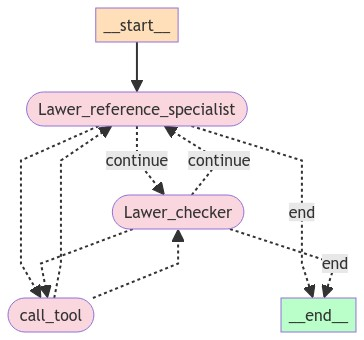

In [58]:

from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [60]:
html_style = ipywidgets.HTML("<style>.jupyter-button { color : white; }</style>")
style = {"description_width": "150px"}
style_button = {"button_color": "rgb(0, 60, 120)", "color": "white"}
style_loi = style.copy()
style_loi["background-color"] = "grey"
param_desc = ipywidgets.Textarea(
    description="Parametre à chercher :", layout=Layout(width="80%"), style=style
)
param_desc.value = """Montant journalier à taux plein à Mayotte de l'allocation de solidarité spécifique (ASS)"""

question = ipywidgets.HTML(
    description="Question complète :", layout=Layout(width="80%"), style=style
)

def on_button_clicked(b):
    # This is the action to take when the button is clicked
    question.value = "Quel est le " + param_desc.value + " selon Légifrance ?" +\
        " Donner également la référence législative et sa date avec le lien vers la page légifrance." +\
        " Vous devez vérifier que la réponse contient une valeur, un lien vers LegiFrance et la dernière date de modification de la loi."
    reponse_llm.value = "Attente de la réponse des agents, cela peut prendre 2 minutes..."
    reponses_des_llm.value = ""
    try:
        i = 0
        for s in graph.stream(
            {
                "messages": [
                    HumanMessage(
                        content=question.value
                    )
                ],
            },
            # Maximum number of steps to take in the graph
            {"recursion_limit": 20},
        ):
            i += 1
            reponses_des_llm.value += f"<b>Réponse {i}</b>"
            reponses_des_llm.value += str(s)[:200]
        # {'Lawer_reference_specialist': {'messages': [HumanMessage(content="FINAL ANSWER\n\nMontant journali
        # Get last answer
        last_answer = s.get(lawer_ref_name)
        if last_answer is None:
            last_answer = s.get(lawer_checker_name)
        markdown_string = last_answer['messages'][-1].content
        reponse_llm.value = markdown.markdown(markdown_string)
    except Exception as e:
        print(f"""
              ===========================================================
              {s}
              ===========================================================
              {e}
              ===========================================================
              """)
        reponse_llm.value = f'<pre>{e}</pre>'
        raise e
    

llm_button = ipywidgets.Button(description="Demander à un LLM", style=style_button)
llm_button.on_click(on_button_clicked)

reponse_llm = ipywidgets.HTML(
    description="Réponse finale :",
    layout=Layout(
        width="90%", border="1px solid rgb(0, 60, 120)", background_color="grey"
    ),
    style=style_loi,
)
reponses_des_llm = ipywidgets.HTML(
    description="Réponses des Agents :",
    layout=Layout(
        width="90%", border="1px solid rgb(0, 60, 120)", background_color="grey"
    ),
    style=style_loi,
)
interface = ipywidgets.VBox(
    [
        html_style,
        param_desc,
        llm_button,
        question,
        reponse_llm,
        reponses_des_llm,
    ],
    layout=Layout(width="100%"),
)
display(interface)